In [ ]:
import pandas as pd
import numpy as np

test_tweets = pd.read_csv("https://raw.githubusercontent.com/wsharvey/DG-Harvey/main/test_tweets_anuFYb8.csv")
train_tweets = pd.read_csv("https://raw.githubusercontent.com/wsharvey/DG-Harvey/main/train.csv")

The types of data per column per dataset can be seen below.

In [ ]:
for col in train_tweets.columns:
    print(f'Column "{col}" in training data has type {type(col)}')
    
for col in test_tweets.columns:
    print(f'Column "{col}" in test data has type {type(col)}')

Column "id" in training data has type <class 'str'>
Column "label" in training data has type <class 'str'>
Column "tweet" in training data has type <class 'str'>
Column "id" in test data has type <class 'str'>
Column "tweet" in test data has type <class 'str'>


In [ ]:
nan_vals = len(train_tweets[train_tweets['tweet'].isna()])
labeled_1 = len(train_tweets[train_tweets['label'] == 1]) 
labeled_0 = len(train_tweets[train_tweets['label'] == 0]) 

print(f"There are {nan_vals} NaN values in the data")
print(f"There are {labeled_0} rows that are NOT classified as hate speech, while there are {labeled_1} rows that are classified as hate speech, leading to imbalanced data")
      

There are 0 NaN values in the data
There are 29720 rows that are NOT classified as hate speech, while there are 2242 rows that are classified as hate speech, leading to imbalanced data


In order to account for this data imbalance, I will use the "resample" module of sklearn.utils, in order to create a balanced data set. This must be done because there are so little samples where hate speech is classified, so the model will ultimately favor classifying new tweets as NOT hate speech because there is such an overwhelming amount of data for this aspect. Since there are no NaN values or outliers, no further data processing has to be done to account for this area.

In [ ]:
from nltk.corpus import wordnet
# function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

In [ ]:
import string 
from nltk.stem.wordnet import WordNetLemmatizer
import nltk
import re
from string import digits
nltk.download('stopwords')
lemmatizer  = WordNetLemmatizer()
stopwords_en   = set(nltk.corpus.stopwords.words('english'))
stopwords_en.add("user")
stopwords_en.add("amp")
punctuation = string.punctuation
def normalize_POS(text):
    # change to lower case and remove punctuation
    text2 = text.lower()
    #removing digits and special characteristics of tweets
    text3 = re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text2)
    #tokenize
    text_tokens = nltk.word_tokenize(text3)
    #remove stop-words
    clean_text  = [t for t in text_tokens if (t not in stopwords_en)]
    # we lemmatize with POS
    text_tagged = nltk.pos_tag(clean_text)
    normalized_text = [lemmatizer.lemmatize(t, nltk_tag_to_wordnet_tag(tag)) if (nltk_tag_to_wordnet_tag(tag) is not None) else  lemmatizer.lemmatize(t) for (t, tag) in text_tagged]

    return normalized_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from sklearn.utils import resample
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

clean_train = []
for tweet in train_tweets['tweet']:
    to_append = normalize_POS(tweet)
    clean_train.append(to_append)

train_tweets['Tweet'] = clean_train
train_tweets = train_tweets.drop(columns = ['tweet'])

clean_test = []
for tweet in test_tweets['tweet']:
    to_append = normalize_POS(tweet)
    clean_test.append(to_append)

test_tweets['Tweet'] = clean_test
test_tweets = test_tweets.drop(columns = ['tweet'])

train_majority = train_tweets[train_tweets['label'] == 0]
train_minority = train_tweets[train_tweets['label'] == 1]
train_minority_upsampled = resample(train_minority, 
                                 replace=True,    
                                 n_samples=len(train_majority),   
                                 random_state=123)
train_upsampled = pd.concat([train_minority_upsampled, train_majority])
train_upsampled['label'].value_counts()

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


1    29720
0    29720
Name: label, dtype: int64

In the above cells, I clean the data using various NLP libraries like NTLK to remove stop words, non-alphanumeric characters, and break up the tweets by word (among other things). After the data is cleaned, the problem of imbalance is dealt with by utilizing the resample method of sklearn to get an even amount of data points between the two classes (labels).

Text(0.5, 1.0, 'Most Popular Words in Hate Comments')

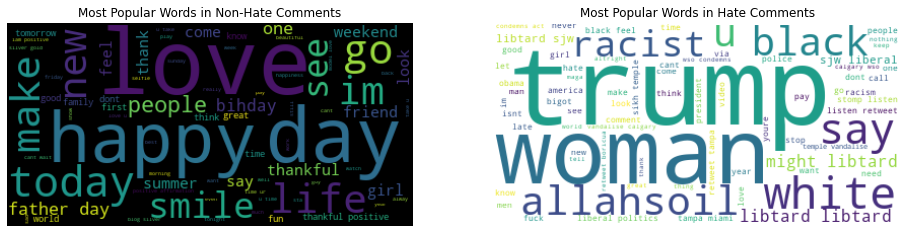

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt



no_hate = [token for tweet in train_tweets[train_tweets['label'] == 0]['Tweet'] for token in tweet]
hate = [token for tweet in train_tweets[train_tweets['label'] == 1]['Tweet'] for token in tweet]

# Create and generate a word cloud image:
wordcloud_hate = WordCloud(max_words=75, background_color="white").generate(' '.join(hate))
wordcloud_no_hate = WordCloud(max_words=75, background_color="black").generate(' '.join(no_hate))

# Display the generated images:
fig, axs = plt.subplots(1,2 , figsize=(16,8))
axs[0].imshow(wordcloud_no_hate, interpolation='bilinear')
axs[0].axis('off')
axs[0].set_title('Most Popular Words in Non-Hate Comments')
axs[1].imshow(wordcloud_hate, interpolation='bilinear')
axs[1].axis('off')
axs[1].set_title('Most Popular Words in Hate Comments')


In [ ]:
import random
baseline = [random.randint(0, 1) for _ in range(len(train_upsampled['label']))]



[0, 0, 0, 0, 0, 0, 1, 0, 1, 0]

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis



In [ ]:
names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier()
    
]

In [ ]:
x_train1, x_test1, y_train, y_test = train_test_split(train_upsampled['Tweet'],
                                                    train_upsampled['label'],random_state = 0)



x_train = [" ".join(i) for i in x_train1]
x_test = [" ".join(i) for i in x_test1]




In [ ]:
from sklearn.pipeline import make_pipeline
best_model = ""
best_score = 0
acc = {}
for name, fam in zip(names, classifiers):
  pipeline = make_pipeline(
    CountVectorizer(),
    TfidfTransformer(),
    fam)

  model = pipeline.fit(x_train, y_train)
  y_predict = model.predict(x_test)
  score = accuracy_score(y_test, y_predict)
  print('--'* 20)
  print(name)
  print('F1_Score: ',f1_score(y_test, y_predict))
  print('Accuracy_Score: ', score)
  print('--'*20) 
  if score > best_score:
    best_model = name
    best_score = score
  acc[name] = score





----------------------------------------
Nearest Neighbors
F1_Score:  0.7715183246073299
Accuracy_Score:  0.7063257065948856
----------------------------------------
----------------------------------------
Linear SVM
F1_Score:  0.9113906456320802
Accuracy_Score:  0.9141991924629879
----------------------------------------
----------------------------------------
RBF SVM
F1_Score:  0.9964836353800378
Accuracy_Score:  0.9965006729475101
----------------------------------------
----------------------------------------
Decision Tree
F1_Score:  0.3173306094654409
Accuracy_Score:  0.595222072678331
----------------------------------------
----------------------------------------
Random Forest
F1_Score:  0.13518588058580547
Accuracy_Score:  0.5350605652759085
----------------------------------------
----------------------------------------
Neural Net
F1_Score:  0.9348210640903524
Accuracy_Score:  0.9355316285329744
----------------------------------------
------------------------------------

TypeError: ignored

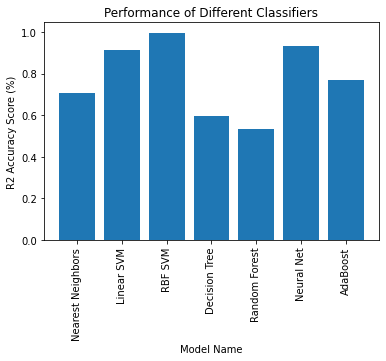

In [ ]:
plt.bar(acc.keys(), acc.values());

plt.xticks(rotation = 90);
plt.title("Performance of Different Classifiers");
plt.xlabel("Model Name");
plt.ylabel("R2 Accuracy Score (%)");

In [ ]:
print(f"The best model was {best_model} performing at a {best_score} accuracy score")

The best model was RBF SVM performing at a 0.9965006729475101 accuracy score


In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
f_pipeline = make_pipeline(
    CountVectorizer(),
    TfidfTransformer(),
    SVC(gamma=2, C=1))


final_model = f_pipeline.fit(x_train, y_train)
pred = final_model.predict(x_test)

print('Confusion_Matrix: ')
print(confusion_matrix(y_test, pred, labels = [1,0]).T)
print('Precision_Score: ', precision_score(y_test, pred, labels = [1,0]))
print('Recall_Score: ', recall_score(y_test, pred, labels = [1,0]))


Confusion_Matrix: 
[[7368   50]
 [   2 7440]]
Precision_Score:  0.9932596387166353
Recall_Score:  0.9997286295793758


In [ ]:
testing = [" ".join(i) for i in test_tweets['Tweet']]

test_tweets['Predicted Label'] = final_model.predict(testing)
test_tweets[test_tweets['Predicted Label'] == 1]

,id,Tweet,Predicted Label
7,31970,"[finishedtattooinkedinkloveit, thanksaleeee]",1
19,31982,"[thought, factory, bbc, neutrality, right, win...",1
34,31997,"[say, im, speak, collectively, ive, always, kn...",1
81,32044,"[lt, feed, public, trough, piggy, michelleobama]",1
110,32073,"[hey, 14000, ivanka, bracelet, feel, good, pro...",1
...,...,...,...
17031,48994,"[comment, reflection, ignorance]",1
17100,49063,"[save, date, 142017, sourcenation, live, wed, ...",1
17128,49091,"[uk, government, new, antisemitism, definition...",1
17176,49139,"[racist, pay, ever]",1


In [ ]:
pred_hate = test_tweets[test_tweets['Predicted Label'] == 1]
pred_no_hate = test_tweets[test_tweets['Predicted Label'] == 0]

print("Example of Detected Hate Speech")
print(" ".join(pred_hate.iloc[400]['Tweet']))

print("\n")

print("Example of No Hate Speech Detected")
print(" ".join(pred_no_hate.iloc[400]['Tweet']))


Example of Detected Hate Speech
jewish group whitewash israeli racism ensure fester gaza palestine israel bd


Example of No Hate Speech Detected
lesson happiness life via
